# Regressão Linear com PyTorch

## Objetivo

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se
- o cálculo do gradiente automático do PyTorch, porém
- a função de perda e
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_iris

import torch
from torch import nn, optim
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(1234)

## Leitura dos dados

In [52]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [53]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [54]:
print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train[:5]:
 [[1.        ]
 [0.71428573]
 [0.952381  ]
 [0.28571424]
 [0.7619048 ]]
y_train[:5]:
 [[0.80952376]
 [0.71428573]
 [0.90476197]
 [0.4761905 ]
 [0.7619048 ]]


In [55]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [56]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428573],
       [1.        , 0.95238101],
       [1.        , 0.28571424],
       [1.        , 0.76190478],
       [1.        , 0.38095227],
       [1.        , 0.66666675],
       [1.        , 0.        ],
       [1.        , 0.80952376],
       [1.        , 0.14285702],
       [1.        , 0.047619  ],
       [1.        , 0.47619051],
       [1.        , 0.52380949],
       [1.        , 0.57142848],
       [1.        , 0.33333325],
       [1.        , 0.85714275],
       [1.        , 0.33333325],
       [1.        , 0.42857149],
       [1.        , 0.61904752],
       [1.        , 0.33333325],
       [1.        , 0.47619051],
       [1.        , 0.57142848],
       [1.        , 0.66666675],
       [1.        , 0.57142848],
       [1.        , 0.71428573],
       [1.        , 0.80952376],
       [1.        , 0.90476197],
       [1.        , 0.85714275],
       [1.        , 0.52380949],
       [1.        , 0.38095227],
       [1.

In [57]:
print('x_train_bias.shape:',x_train_bias.shape, x_train_bias.dtype)

x_train_bias.shape: (50, 2) float64


In [58]:
x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)
print(y_train)

tensor([[0.8095],
        [0.7143],
        [0.9048],
        [0.4762],
        [0.7619],
        [0.7143],
        [0.8095],
        [0.1429],
        [0.7619],
        [0.4286],
        [0.2381],
        [0.5714],
        [0.4762],
        [0.8095],
        [0.2857],
        [0.6667],
        [0.7143],
        [0.5238],
        [0.7143],
        [0.4286],
        [0.8571],
        [0.4762],
        [0.9048],
        [0.8095],
        [0.6190],
        [0.6667],
        [0.8571],
        [0.9524],
        [0.7143],
        [0.2381],
        [0.3810],
        [0.3333],
        [0.4286],
        [1.0000],
        [0.7143],
        [0.7143],
        [0.8095],
        [0.6667],
        [0.5238],
        [0.4762],
        [0.6667],
        [0.7619],
        [0.4762],
        [0.1429],
        [0.5714],
        [0.5714],
        [0.5714],
        [0.6190],
        [0.0000],
        [0.5238]])


## Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

In [59]:
#Inicialização usando toch.nn.Linear

model = torch.nn.Linear(in_features=2, out_features=1, bias=False)

### Verificando a inicialização dos parâmetros

In [60]:
model.weight.data = torch.zeros(1,2)
torch.nn.init.uniform(model.weight.data, -0.1, 0.1)
model.weight

Parameter containing:
tensor([[-0.0480, -0.0267]], requires_grad=True)

### Testando o predict da rede

In [61]:
xx = torch.ones((5,2))
xx

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [62]:
model(Variable(xx))

tensor([[-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747]], grad_fn=<MmBackward0>)

## Treinamento

In [63]:
num_epochs = 100
learning_rate = 0.5
w0_list = []
w1_list = []
for epoch in range(num_epochs):
    #inputs = Variable(x_train_bias)
    #target = Variable(y_train)
    inputs = x_train_bias
    target = y_train

    # forward - predict
    y_pred = model(inputs)

    w0_list.append(model.weight.data[0][0].item())
    w1_list.append(model.weight.data[0][1].item())

    #loss cálculo da função de perda
    loss = torch.mean((y_pred - target)**2)

    # backward propagation - cálculo gradient
    loss.backward()

    # gradiente descendente
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data

    # zeragem parâmetros próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data))

Epoch[20/100], loss: 0.022983
Epoch[40/100], loss: 0.021432
Epoch[60/100], loss: 0.021207
Epoch[80/100], loss: 0.021175
Epoch[100/100], loss: 0.021170


## Avaliação

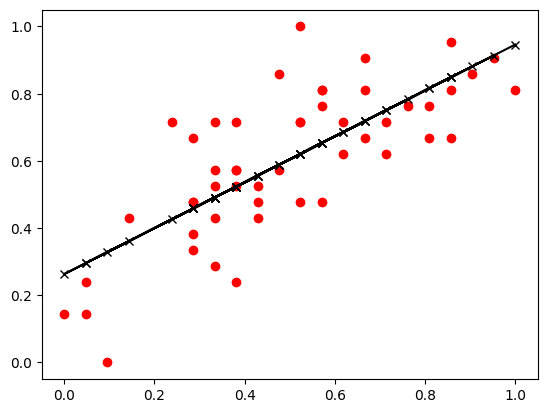

In [64]:
y_pred = model(Variable(x_train_bias))
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

### Acessando os parâmetros

In [65]:
w_dic = model.state_dict()
w_dic

OrderedDict([('weight', tensor([[0.2631, 0.6830]]))])

### Parâmetros ótimos, solução analítica

In [66]:
x_bias = x_train_bias
y = y_train
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


# Exercícios

- 1) Por que no final da varredura do laço de treinamento, a perda é impressa utilizando
   `loss.data`? Por que precisa do `data`?

   **R - O loss é do um objeto Tensor e pra acessar o valor é precso acessar a propreidade data.**
   

- 2) Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já
   treinados.

In [67]:
#Valor ótimo, solução analítica
x_bias = x_train_bias
y = y_train
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


In [68]:
model.weight.data = torch.zeros(1,2)
model.weight.data.copy_(w_opt[0:1,:])
torch.nn.init.uniform(model.weight.data)
model.weight

Parameter containing:
tensor([[0.0583, 0.7006]], requires_grad=True)

## Testando o predict da rede

In [69]:
xx = torch.ones((5,2))
xx

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [70]:
model(Variable(xx))

tensor([[0.7589],
        [0.7589],
        [0.7589],
        [0.7589],
        [0.7589]], grad_fn=<MmBackward0>)

## Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já treinados.

In [71]:
#loss cálculo da função de perda
loss2 = torch.mean((y_pred - target)**2)

In [72]:
print('loss: {:.6f}'.format(loss2.data))

loss: 0.021170


#Questão 3

- 3) Crie duas listas `w0_list` e `w1_list` para guardar a evolução dos valores dos
   parâmetros durante o laço de treinamento.
   Modifique o exemplo do gráfico tipo **scatter plot** para visualizar a variação
   dos parâmetros do modelo duas dimensões.
   Marque neste gráfico o valor ótimo do parâmetro dado pela solução
   analítica.

In [73]:
print(f"Lista de evolução de w0: {w0_list}")
print(f"Lista de evolução de w1: {w1_list}")

Lista de evolução de w0: [-0.04803116247057915, 0.6131580471992493, 0.4314092993736267, 0.46557363867759705, 0.44516679644584656, 0.43924957513809204, 0.43015623092651367, 0.42237430810928345, 0.4147339463233948, 0.40751150250434875, 0.40061497688293457, 0.39404743909835815, 0.38778868317604065, 0.38182532787323, 0.3761431872844696, 0.370728999376297, 0.36557015776634216, 0.3606546223163605, 0.3559708893299103, 0.35150808095932007, 0.34725573658943176, 0.34320393204689026, 0.33934319019317627, 0.3356645405292511, 0.3321593999862671, 0.32881954312324524, 0.32563719153404236, 0.3226049542427063, 0.3197157084941864, 0.31696271896362305, 0.3143395483493805, 0.31184008717536926, 0.30945852398872375, 0.30718928575515747, 0.3050270676612854, 0.30296680331230164, 0.30100372433662415, 0.29913321137428284, 0.2973509132862091, 0.29565268754959106, 0.29403451085090637, 0.29249268770217896, 0.2910235822200775, 0.2896237373352051, 0.2882899045944214, 0.2870190143585205, 0.2858080267906189, 0.2846541

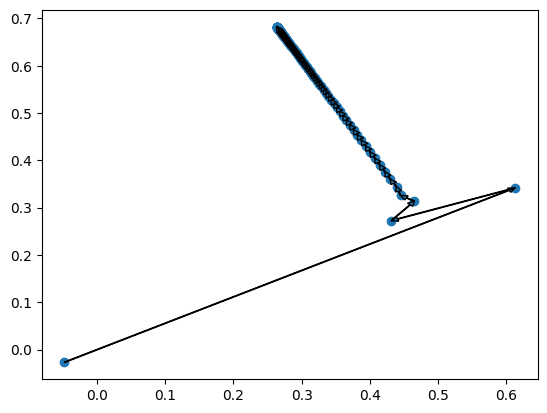

In [74]:
# Exemplo
#w0_list = [0.1, 0.15, 0.2, 0.3]
#w1_list = [0.1, 0.2, 0.18, 0.3]
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1

# Aprendizados